# About Data 📑

- Image dataset of **20** classes of head gear-hats,caps, helmets. 
- **3620** train images,**100** test and **100** validation images. 
- All images are **224 X 224 X 3** in jpg format. 

# Import Libs 🔗

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import warnings
warnings.filterwarnings('ignore')


import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


In [76]:
# Constants 
SPLIT_SIZE = .2
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
EPOCHS=20

# Load Data 🔋 🔌

In [67]:
# Create some folders that will store the training and test data.

TRAINING_DIR ="/kaggle/input/headgear-image-classification/train/"
Valid_DIR="/kaggle/input/headgear-image-classification/valid/"
TESTING_DIR ="/kaggle/input/headgear-image-classification/test/"

train_data = image_dataset_from_directory(TRAINING_DIR,
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE
                                         )

val_data = image_dataset_from_directory(Valid_DIR,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE
                                       )

test_data = image_dataset_from_directory(TESTING_DIR,
                                         batch_size=BATCH_SIZE,
                                         image_size=IMG_SIZE
                                        )

Found 3620 files belonging to 20 classes.
Found 100 files belonging to 20 classes.
Found 100 files belonging to 20 classes.


In [38]:
for images, labels in train_data.take(1):
    print(images.shape)

(64, 224, 224, 3)


# Explore Data 🔭 💡

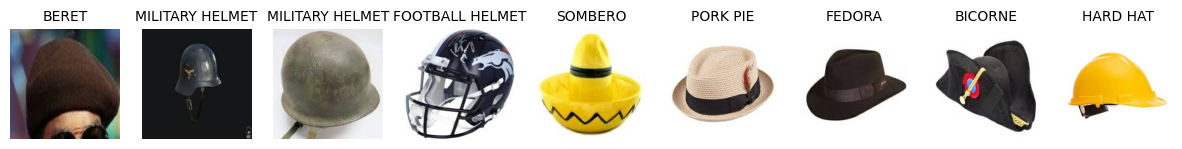

In [39]:
plt.figure(figsize=(15, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(1, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]], fontsize=10)
    plt.axis("off")

**Extract labels**
What the following line does:

- pass on each label in data : `for label in train_data.class_names`
- get the file names in that label's folder : `os.listdir(f"{data_path}/{label}")`
- get the count of the file names: `len()`
- create a dictionary entry with that label name and count: `label : len(..)`

In [40]:
label_counts = {label : len( os.listdir(f"{TRAINING_DIR}/{label}") ) for label in train_data.class_names }
NUM_CLASSES = len(label_counts)

In [41]:
#convert the dict to a pandas series for easier manipulation
label_counts = pd.Series(label_counts)
type(label_counts)

pandas.core.series.Series

In [42]:
label_counts.sort_values(ascending=False, inplace=True)

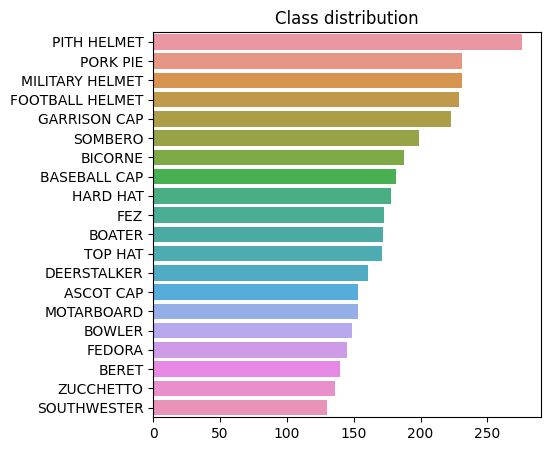

In [43]:
plt.figure(figsize=(5,5))
ax = sns.barplot(x=label_counts.values[:50], y=label_counts.index[:50])
ax.set_title("Class distribution")
plt.show()

In [44]:
#Classes with less than 150 images
label_counts[label_counts < 150]

BOWLER         149
FEDORA         145
BERET          140
ZUCCHETTO      136
SOUTHWESTER    130
dtype: int64

In [45]:
# get CLASSES_NAMES from the first column of the series
CLASSES_NAMES = label_counts.index.values
CLASSES_NAMES

array(['PITH HELMET', 'PORK PIE', 'MILITARY HELMET', 'FOOTBALL HELMET',
       'GARRISON CAP', 'SOMBERO', 'BICORNE', 'BASEBALL CAP', 'HARD HAT',
       'FEZ', 'BOATER', 'TOP HAT', 'DEERSTALKER', 'ASCOT CAP',
       'MOTARBOARD', 'BOWLER', 'FEDORA', 'BERET', 'ZUCCHETTO',
       'SOUTHWESTER'], dtype=object)

# Build Model 🔩 ⚙️

Since we have a relatively small dataset with alot of classes and many of those classes have few images, fine-tuning a pretrained model would be a better choice than training a model from scratch

Let's try a `ResNet50` to see how well it would perform on our data

## Pre-process data
- perform normalization on images in training and validation set ,using the function `preprocess_image_input` from the `ResNet50` model in Keras.

In [46]:
def preprocess_image_input(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [47]:
train_data = train_data.map(preprocess_image_input)
val_data = val_data.map(preprocess_image_input)



## Define the Network
Performing transfer learning on **ResNet50** available in Keras.
- load pre-trained **imagenet weights** to the model.
- choose to retain all layers of **ResNet50** along with the final classification layers.

In [48]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor




In [49]:
'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    return x



In [50]:
'''
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

#     resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


In [55]:

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer= tf.keras.optimizers.Adam(), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model



In [56]:

model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                             

# Train Model  🧪 ⚗️

In [77]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data = val_data,
                    batch_size=BATCH_SIZE)


Epoch 1/20
57/57 [==============================] - 19s 322ms/step - loss: 0.1763 - accuracy: 0.9511 - val_loss: 1.8068 - val_accuracy: 0.6400
Epoch 2/20
57/57 [==============================] - 19s 325ms/step - loss: 0.1297 - accuracy: 0.9558 - val_loss: 1.5660 - val_accuracy: 0.6500
Epoch 3/20
57/57 [==============================] - 19s 324ms/step - loss: 0.0987 - accuracy: 0.9682 - val_loss: 2.8056 - val_accuracy: 0.7200
Epoch 4/20
57/57 [==============================] - 19s 323ms/step - loss: 0.1385 - accuracy: 0.9586 - val_loss: 0.9950 - val_accuracy: 0.8100
Epoch 5/20
57/57 [==============================] - 19s 326ms/step - loss: 0.0744 - accuracy: 0.9785 - val_loss: 0.3746 - val_accuracy: 0.9100
Epoch 6/20
57/57 [==============================] - 19s 321ms/step - loss: 0.0500 - accuracy: 0.9870 - val_loss: 0.9679 - val_accuracy: 0.8400
Epoch 7/20
57/57 [==============================] - 19s 324ms/step - loss: 0.0315 - accuracy: 0.9920 - val_loss: 0.5246 - val_accuracy: 0.9000

# Plot Loss and Accuracy Curves  📊 📈

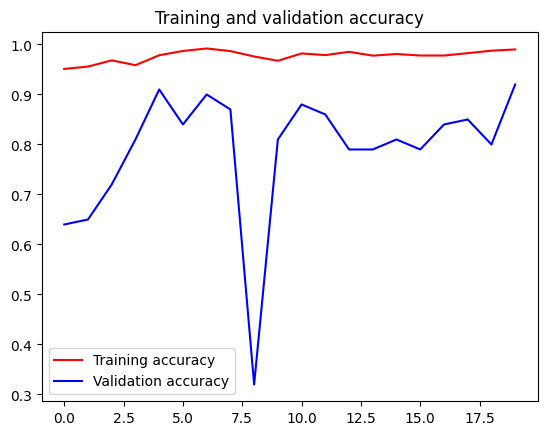

<Figure size 640x480 with 0 Axes>

In [78]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Evaluate the Model ⚖️



Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [79]:
loss, accuracy = model.evaluate(val_data, batch_size=BATCH_SIZE)

2/2 [==============================] - 0s 74ms/step - loss: 0.4260 - accuracy: 0.9200


# Test Model 🔮

In [96]:
# Get the predicted probabilities for the images
probabilities = model.predict(test_data)
probabilities = np.argmax(probabilities, axis = 1)
probabilities

2/2 [==============================] - 0s 102ms/step


array([ 8, 16,  5, 10, 10, 12, 18,  1,  8,  4,  1,  0,  7, 14, 15,  6,  3,
       18, 10,  9,  9, 18,  2,  6, 15, 16,  8,  4, 16, 18,  5, 19,  6, 10,
        2, 12,  0,  5, 14,  6, 14,  3, 11, 17,  6,  4, 19, 12,  4, 15,  9,
        7, 11, 13,  1, 11,  0, 16,  9, 16, 16,  5,  8,  7,  1,  3, 10, 12,
        1, 15,  8, 13, 17,  5, 17,  9, 19,  0,  2,  8,  0, 19, 13,  4,  7,
       11, 19,  0,  8, 14,  9,  0,  4,  8,  3, 14,  3,  4, 17, 13])

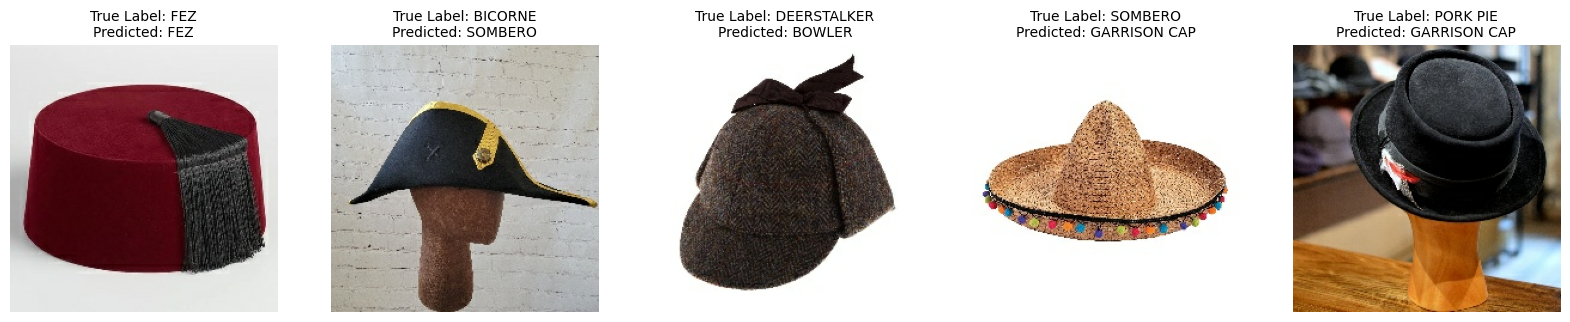

In [97]:
plt.figure(figsize=(20, 10))
for images, labels in test_data.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the class name for the true label and predicted label
        true_label = 'True Label: '+test_data.class_names[labels[i]]
        predicted_label = 'Predicted: '+test_data.class_names[probabilities[i]]
        # Set the titles for the subplot
        plt.title(f"{true_label}\n{predicted_label}", fontsize=10)
        plt.axis("off")